# Images classification with Huggingface
## 2023-04-25

https://huggingface.co/docs/transformers/tasks/image_classification

In [1]:
# loading modules

from datasets import load_dataset, load_metric
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import DefaultDataCollator
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import pipeline
import numpy as np

/home/dqmis/projects/ai-course/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
food = load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)

Found cached dataset food101 (/home/dqmis/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


In [3]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=288x512>,
 'label': 77}

In [4]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [22]:
MODEL_NAME = "google/vit-base-patch16-224"

In [23]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

In [24]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [25]:
food = food.with_transform(transforms)

In [26]:
data_collator = DefaultDataCollator()

## Defining metrics

In [27]:
accuracy = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Defining model

In [28]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    ignore_mismatched_sizes=True,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training loop

In [29]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/dqmis/projects/ai-course/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=186, training_loss=0.6893421661469245, metrics={'train_runtime': 340.1138, 'train_samples_per_second': 35.282, 'train_steps_per_second': 0.547, 'total_flos': 9.232831524962304e+17, 'train_loss': 0.6893421661469245, 'epoch': 2.98})

In [30]:
trainer.save_model("trained_model")

## Inference

In [31]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

Found cached dataset food101 (/home/dqmis/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


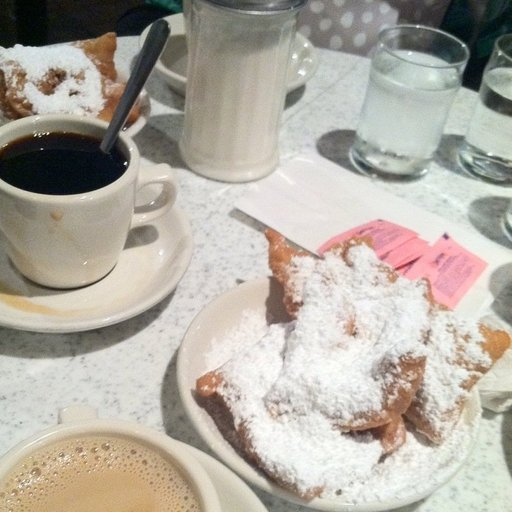

In [32]:
image

In [33]:
classifier = pipeline("image-classification", model="trained_model")
classifier(image)

[{'score': 0.9887561202049255, 'label': 'beignets'},
 {'score': 0.002946669701486826, 'label': 'chicken_wings'},
 {'score': 0.0011774359736591578, 'label': 'bruschetta'},
 {'score': 0.0009322736295871437, 'label': 'prime_rib'},
 {'score': 0.0004944362444803119, 'label': 'hamburger'}]